# Bollinger Bands Strategy and Backtesting

Prepared by Samalie Piwan   
Email : spiwan@andrew.cmu.edu

## 1. Strategy Implementation

Load the libraries to be used in the project

In [1644]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from backtesting import Backtest, Strategy
from tabulate import tabulate
import os
import csv
backtesting.set_bokeh_output(notebook=False)

Define the function bb_backtest_strategy() that implements and plots the Bollinger Bands

In [1546]:
def bb_backtest_strategy(symbol, data, date_col, pricing_col, param_window, param_std):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        param_window:
            The number of days to use when computing the Simple Moving Average
        param_length:
            The short period, also used when calculating the SMA
        param_std:
            The long period
            
    Return
    -----------
        None
    
    """

    main_df_indexed = data
    
    #Generate the bollinger bands
    #length (int): The short period. Default: 5
    #std (int): The long period. Default: 2
    #Function returns lower, mid, upper, bandwidth, and percent columns
    
    main_df_indexed.ta.bbands(close = pricing_col, length = sma_window, std= param_std, append = True)

    #Create f strings for the column names
    str_upper_band = f"BBU_{sma_window}_{std}.0"
    str_middle_band = f"BBM_{sma_window}_{std}.0"
    str_lower_band = f"BBL_{sma_window}_{std}.0"

    # Generate the trading signals
    # 1 Represents a buy
    # -1 represents a sell
    # 0 represents a hold
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        # Today's price is below the lower band
        # The price has dropped below the bands and a rise is expected
        # We want to buy

        if main_df_indexed[pricing_col][i] < main_df_indexed[str_lower_band][i]:
            # If we are not already in a buy position
            # Add today's price to the buy list
            # Update the signal to show we are in buy
            signal = 1
            bands_signal.append(signal)

        # Today's price is above the upper band
        # The price has increased above the bands and a drop is expected
        # We want to sell
        elif main_df_indexed[pricing_col][i] > main_df_indexed[str_upper_band][i]:

            # If we are not already in a sell position
            # Add today's price to the sell list
            # Update the signal to show we are in sell
            signal = -1
            bands_signal.append(signal)
        else:
            signal = 0
            bands_signal.append(signal)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        # If we are in a buy position, set our position as buy
        if bands_signal[i] == 1:
            position[i] = 1
        # If we are in a sell position, set our position as sell
        elif bands_signal[i] == -1:
            position[i] = 0
        # Otherwise use yesterday's position
        else:
            position[i] = position[i-1]
            
    plt_df = main_df_indexed.copy().dropna()
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Closing Price | SMA "+str(param_window))
    plt_df[pricing_col].plot(label = 'Prices', color = 'skyblue')
    plt_df[str_upper_band].plot(label = 'Upper Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt_df[str_middle_band].plot(label = 'Middle Band '+str(param_window), linestyle = '--', linewidth = 1.2, color = 'grey')
    plt_df[str_lower_band].plot(label = 'Lower Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt.fill_between(plt_df.index, plt_df[str_lower_band],plt_df[str_upper_band], color='grey', alpha = 0.05)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper right')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Signal'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Position'] = position
    
    # Calculate Returns and Cummulative Returns and append to the DataFrame
    
    #New column name is LOGRET_1
    main_df_new.ta.log_return(close=pricing_col, append=True)
    
    #New column name is CUMLOGRET_1
    main_df_new.ta.log_return(close=pricing_col,cumulative=True, append=True)
    
    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Position'] * main_df_new['LOGRET_1']
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()
    
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Equity Lines | SMA "+str(param_window))
    plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()

Declare the Simple Moving Average Window  and Standard Deviation to run the first version of the strategy with

In [1547]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
sma_window = 20
std = 2

### 1.1 Testing the strategy with re-sampled data

Set the initial parameters for loading the data<br>
We use an interval of 30 minutes which can be resampled to 1 hour data<br>
Because we cannot fetch 30 minute data beyond 60 days, we use start date 2023-08-20 that is less than 60 days before today (2023-10-17)

In [1548]:
forex_pair = "EURUSD=X"
interval = "30m"

In [1549]:
# Download monthly data for the specified forex pair
data = yf.download(forex_pair, interval = interval, start = '2023-08-20')

[*********************100%%**********************]  1 of 1 completed


Resample the 30-minute data to 1 hour OHLC data

In [1550]:
ohlc_data = data.resample("1H").apply({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume': 'sum'})

Run the **bb_backtest_strategy()** function on the Intraday FX data to plot the Bollinger Bands, and the performance of the strategy against the returns

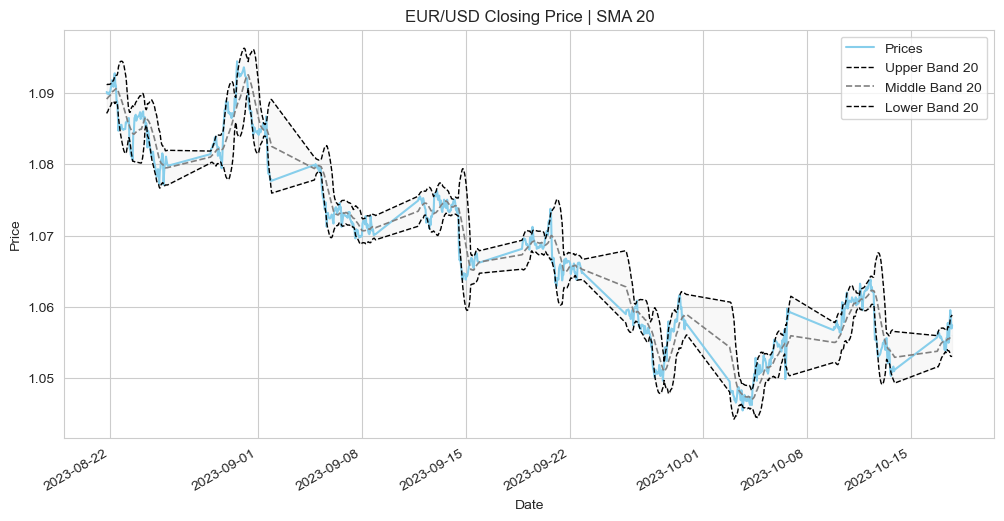

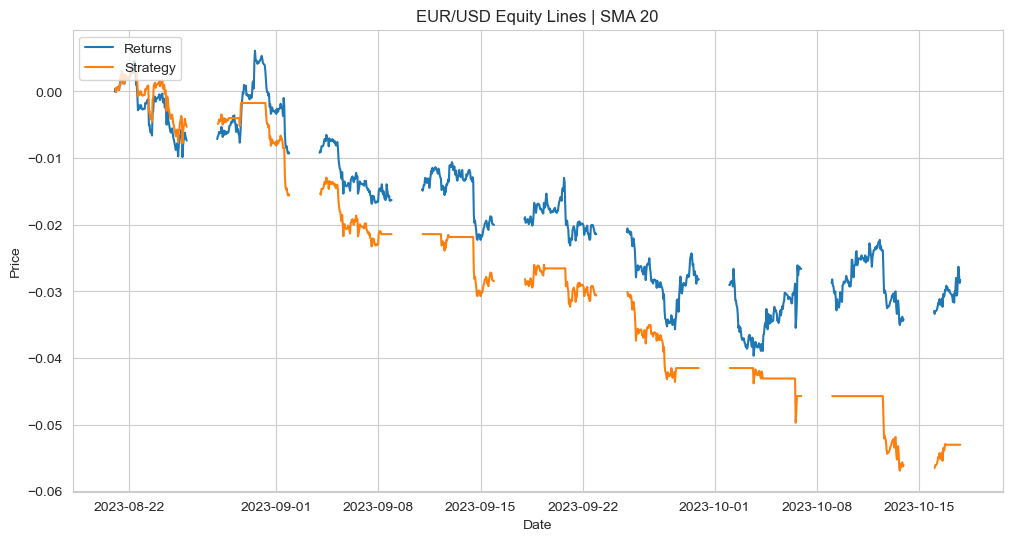

In [1551]:
bb_backtest_strategy(forex_pair, ohlc_data, 'timestamp', 'Close', param_window = sma_window, param_std = std)

### 1.2 Backtesting the strategy on historical data  - Jan 2005 to Dec 2022

Load the historical data from the **Yahoo Finance** API. The appraoch will be to split the data into two datasets:
1. **'backtest_dataset'** - Contains 2018 to 2020 to use for backtesting the strategy
2. **'rerun_dataset'** - Contains 2020 to 2022 for re-testing the strategy with optimized parameters after backtesting

In [1573]:
#Seperate the data into two sets:
test_dataset = yf.download(forex_pair, interval="1wk", start='2005-01-01', end = '2022-12-31')

[*********************100%%**********************]  1 of 1 completed


In [1574]:
backtest_dataset = pd.DataFrame(test_dataset.loc['2005-01-01' : '2013-12-31'].copy())
rerun_dataset = pd.DataFrame(test_dataset.loc['2014-01-01':'2022-12-31'].copy())

Run the **bb_backtest_strategy()** function on backtest_dataset to plot the Bollinger Bands, and the performance of the strategy against the returns

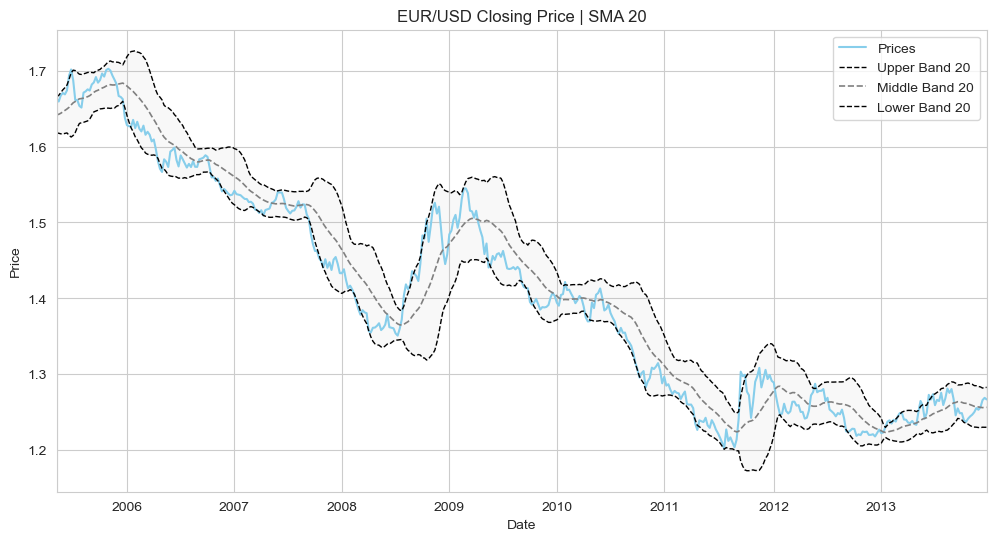

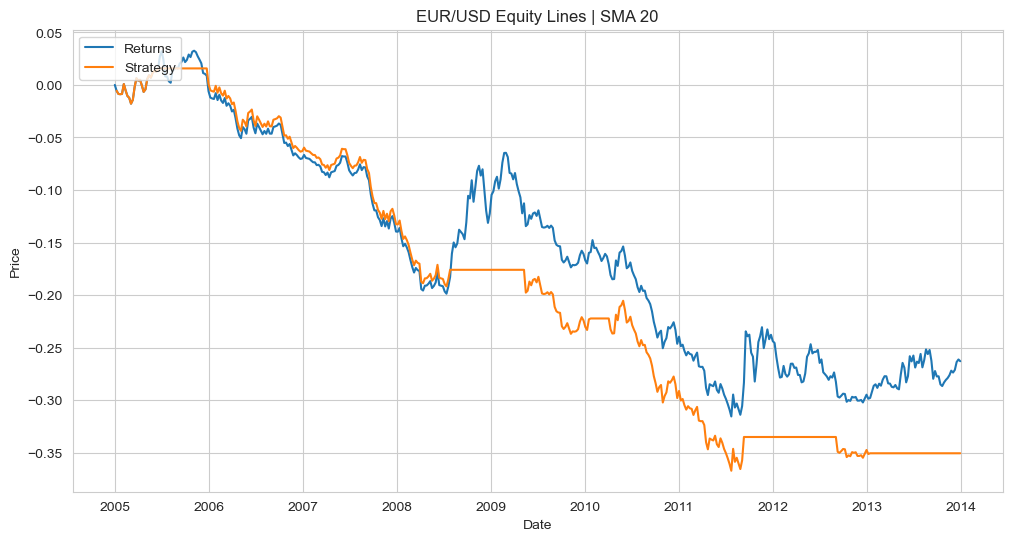

In [1575]:
bb_backtest_strategy(forex_pair, backtest_dataset, 'timestamp', 'Close', sma_window, std)

## 2. Backtesting

### 2.1 Backtesting Strategy Setup

For this strategy, we will focus on optimizing the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Standard Deviation

Define the Indicator(Bollinger Bands) and Buy / Sell Strategy that the backtesting.py library will optimize

In [1576]:
def indicator(data, window, std_dev):
    bbands = ta.bbands(close = data.Close.s, length = window, std = std_dev)
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
        
    sma_window = 20
    std = 2
    
    def init(self):
        self.bbands = self.I(indicator, self.data, self.sma_window, self.std)
        
    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]

        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] < lower_band[-1]:
                self.buy()

Create and an instance of our Backtest class using:
- The **'backtest_dataset'** from section 2
- Cash of $10,000
- Commission at 1%
- SMA window of 20
- Standard Deviation of 2

In [1577]:
bt = Backtest(backtest_dataset, BollingerBandsStrategy, cash=10_000, commission=0.01)
stats = bt.run()

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [1578]:
pnl_backtest = np.cumsum(stats['_trades'])
pnl_backtest_val = pnl_backtest['PnL'].iloc[-1]

In [1579]:
backtest_results_table = [["Peak Equity", stats['Equity Peak [$]']],["Final Equity",stats['Equity Final [$]']],["Sharpe Ratio", round(stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(pnl_backtest_val,3)}"],
                          ["Return %", f"{round(stats['Return [%]'], 3)}%"]]
print(f"Backesting reults with investment of {10000} and commission of 1%\n")
print(tabulate(backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with investment of 10000 and commission of 1%

Result        Value
------------  -----------------
Peak Equity   10000.0
Final Equity  7777.961357274056
Sharpe Ratio  0.0
PnL           $-2222.039
Return %      -22.22%


Plot the Close-to-Close equity lines

In [1580]:
backtest_pnl = pd.DataFrame(stats['_trades']["PnL"].copy())
backtest_pnl["PnL CumSum"] = backtest_pnl["PnL"].cumsum()

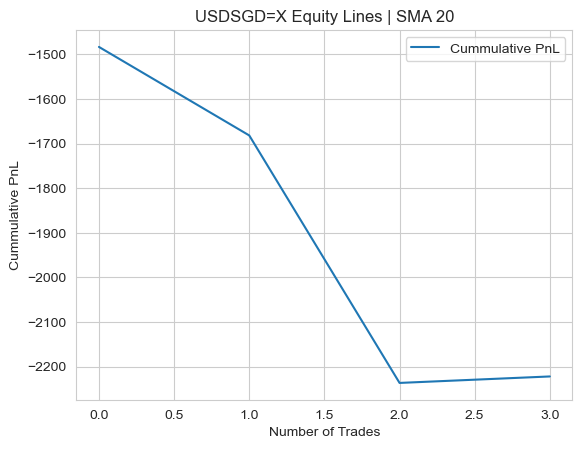

In [1581]:
#Plot the figures with the trading signals
plt.title(forex_pair+" Equity Lines | SMA "+str(sma_window))
plt.plot(backtest_pnl.index, backtest_pnl["PnL CumSum"], label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 2.2 Optmizing strategy to select best-performing hyperparameters

Run the backesting.py **optimize()** function using the Simple Moving Average Window and Standard Deviation as the parameters to optmize

In [1582]:
optimized_stats, heatmap = bt.optimize(
    sma_window = range(20, 31, 1),
    std = list(np.round(np.linspace(1, 3, 11), 1)),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm = heatmap.groupby(["sma_window", "std"]).mean().unstack()

  0%|          | 0/13 [00:00<?, ?it/s]

Create a second table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the optimized backtest

In [1583]:
pnl_optimized = np.cumsum(stats_opt['_trades'])
pnl_optimized_val = pnl_optimized['PnL'].iloc[-1]

In [1584]:
optimized_backtest_results_table = [["Peak Equity", optimized_stats['Equity Peak [$]']],["Final Equity",optimized_stats['Equity Final [$]']],["Sharpe Ratio", round(optimized_stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(pnl_optimized_val,3)}"],
                          ["Return %", f"{round(optimized_stats['Return [%]'], 3)}%"]]
print(f"Backesting reults with SMA Window and Standard Deviation optimized\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with SMA Window and Standard Deviation optimized

Result        Value
------------  ----------------
Peak Equity   10000.0
Final Equity  9890.32238990426
Sharpe Ratio  0.0
PnL           $502.154
Return %      -1.097%


Plot a heatmap of the best-performing hyperparameters

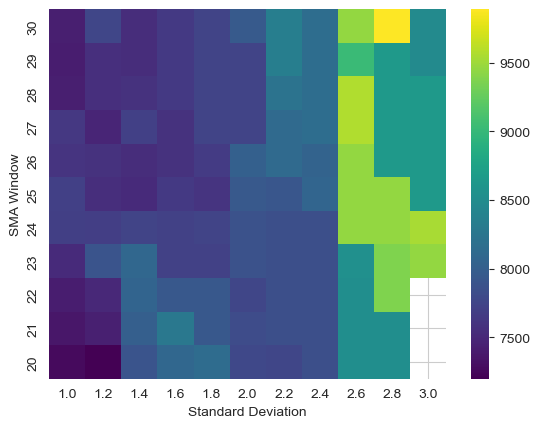

In [1585]:
pricing_hm = sns.heatmap(hm[::-1], cmap='viridis')
pricing_hm.set(xlabel='Standard Deviation', ylabel='SMA Window')
plt.show()

### 2.3 Cross validation

Get the optimal parameters

In [1565]:
optmized_std = optimized_stats['_strategy'].std
optimized_window = optimized_stats['_strategy'].sma_window

print(f"Optimal standard deviation is {optmized_std}")
print(f"Optimal SMA Window is {optimized_window}")

Optimal standard deviation is 2.0
Optimal SMA Window is 25


Run an instance of our Backtest class using  from section 2 using:
- The **'rerun_dataset'** from section 2
- Cash of $10,000
- Commission at 1%

In [1566]:
class OptBollingerBandsStrategy(Strategy):
    
    sma_window = optimized_window
    std = optmized_std
    
    def init(self):
        self.bbands = self.I(indicator, self.data, self.sma_window, self.std)
        
    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]

        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] < lower_band[-1]:
                self.buy()

In [1567]:
bt_optimal = Backtest(rerun_dataset, OptBollingerBandsStrategy, cash=10_000, commission=0.01)
stats_optimal = bt_optimal.run()

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [1568]:
pnl_rerun = np.cumsum(stats_optimal['_trades'])
pnl_rerun_val = pnl_rerun['PnL'].iloc[-1]

In [1569]:
optimized_backtest_results_table = [["Peak Equity", stats_optimal['Equity Peak [$]']],["Final Equity",stats_optimal['Equity Final [$]']],
                                    ["Sharpe Ratio", round(stats_optimal['Sharpe Ratio'], 5)], 
                                      ["PnL", f"${round(pnl_rerun_val,3)}"],
                                      ["Return %", f"{round(stats_optimal['Return [%]'], 3)}%"]]
print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result        Value
------------  ------------------
Peak Equity   10000.0
Final Equity  7301.7161212050905
Sharpe Ratio  0.0
PnL           $-2698.284
Return %      -26.983%


Plot Close to Close Equity Lines

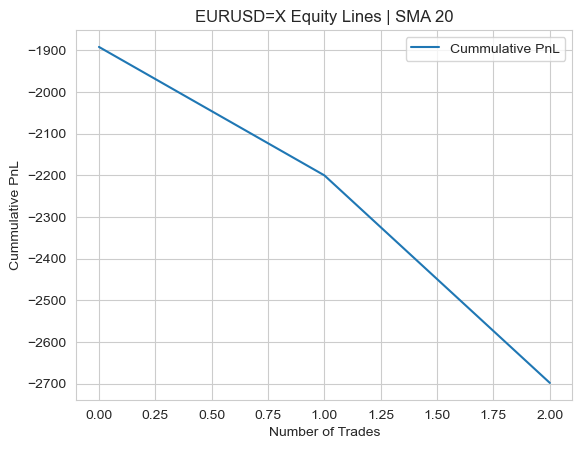

In [1570]:
rerun_pnl = pd.DataFrame(stats_optimal['_trades']["PnL"].copy())
rerun_pnl["PnL CumSum"] = rerun_pnl["PnL"].cumsum()

#Plot the figures with the trading signals
plt.title(forex_pair+" Equity Lines | SMA "+str(sma_window))
plt.plot(rerun_pnl.index, rerun_pnl["PnL CumSum"], label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 3. Bulk Backtesting and Cross-Validation + Saving Metrics

Create a list of the currency pairs to test

In [1607]:
currency_pairs = ['EURUSD=X', 'USDJPY=X', 'GBPUSD=X', 'AUDUSD=X', 'USDCAD=X', 'USDCHF=X', 'EURGBP=X', 'EURJPY=X', 'GBPJPY=X', 'EURCHF=X', 'USDNOK=X', 'USDCNY=X', 'USDMXN=X', 'USDHKD=X', 'USDSGD=X']

Download the data from the API for each and save it into a csv file

In [1621]:
for forex_pair in currency_pairs:
    
    data =  yf.download(forex_pair, interval="1wk", start='2005-01-01', end = '2022-12-31')

    #Seperate the data into two sets, 2005 to 2013 and 2014 to 2022
    backtest_dataset = pd.DataFrame(data.loc['2005-01-01' : '2013-12-31'].copy())
    rerun_dataset = pd.DataFrame(data.loc['2014-01-01':'2022-12-31'].copy())
    
    backtest_filename = "backtest"+forex_pair+".csv"
    rerun_filename = "rerun"+forex_pair+".csv"

    backtest_dataset.to_csv("backtestdata/"+backtest_filename)
    rerun_dataset.to_csv("rerundata/"+rerun_filename)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### 3.1 Backtest and save historical data

Define the function that will run the backtests for the currency pair list above using the strategy **BollingerBandsStrategy**. Backtest the 15 currency pairs with the bollinger bands strategy, using the saved historical data for 2005 to 2013 in the directory backtestdata/

In [1738]:
backtest_results = []
backtest_dir = 'backtestdata'
files = os.listdir(backtest_dir)

def backtest_strategy(param_cash, param_commission):
    index = 0
    while index < len(files):
        try:
            filename = backtest_dir+"/"+files[index]
            symbol = filename[21:27]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(data_df['Date'])
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run()
            backtest_results.append(list([symbol, stats]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return backtest_results

In [1739]:
bulk_backtest_results = backtest_strategy(10_000, 0.01)

Save the **backtest** metrics into a list and write the data into a csv file

In [1740]:
backtest_metrics = []
header = ["Currency Pair", "Final Equity", "PnL", "Return Pct", "Sharpe Ratio", "Win Rate", "Profit Factor", "Number of Trades"]

for result in bulk_backtest_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    #We will write the currency pair, final equity, PnL, return pct, sharpe ratio, win rate, profit factor, number of trades, 
    backtest_metrics.append(list([
        result[0],
        result[1]['Equity Final [$]'],
        result_pnl,
        result[1]['Return [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Win Rate [%]'],
        result[1]['Profit Factor'],
        len(result[1]['_trades'])
    ]))

Write the data to the file **backtest_metrics.csv**

In [1741]:
with open('backtest_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(backtest_metrics)

### 3.2 Cross-validate and save cross-validation data

Define the function that will run the backtests for the currency pair list above using the strategy **OptBollingerBandsStrategy**. Backtest the 15 currency pairs with the optimized bollinger bands strategy, using the saved data for 2013 to 2022 in the directory rerundata/

In [1742]:
validate_results = []
validate_dir = 'rerundata'
validate_files = os.listdir(validate_dir)

def validate_strategy(param_cash, param_commission):
    index = 0
    while index < len(validate_files):
        try:
            filename = validate_dir+"/"+validate_files[index]
            symbol = filename[15:21]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(data_df['Date'])
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, OptBollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run()
            validate_results.append(list([symbol, stats]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return validate_results

In [1743]:
bulk_validate_results = validate_strategy(10_000, 0.01)

Save the **validation** metrics into a list and write the data into a csv file

In [1744]:
for result in bulk_validate_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    #We will write the currency pair, final equity, PnL, return pct, sharpe ratio, win rate, profit factor, number of trades, 
    validate_metrics.append(list([
        result[0],
        result[1]['Equity Final [$]'],
        result_pnl,
        result[1]['Return [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Win Rate [%]'],
        result[1]['Profit Factor'],
        len(result[1]['_trades'])
    ]))

Write the data to the file **validation_metrics.csv**

In [1745]:
with open('validation_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(validate_metrics)